In [1]:
import tensorflow as tf

import os
import time
import cv2
import numpy as np
import shutil
from glob import glob

from matplotlib import pyplot as plt

In [61]:
# Generate cross validation train & test dataset
folder = 'Y-shaped\\'
pic = np.zeros([1,1])
def cross_validation(validnum):
    shutil.rmtree(folder + 'point_folder\\train')
    shutil.rmtree(folder + 'point_folder\\test')
    os.mkdir(folder + 'point_folder\\train')
    os.mkdir(folder + 'point_folder\\test')
    for i in range(5):
        files = glob(os.path.join(folder, 'point_folder', 'group' + str(i), '*.png'))
        if i == validnum:
            for file in files:
                name = list(file.split('\\'))[-1]
                cv2.imwrite(folder + 'point_folder\\test\\' + name, pic)
        else:
            for file in files:
                name = list(file.split('\\'))[-1]
                cv2.imwrite(folder + 'point_folder\\train\\' + name, pic)
                cv2.imwrite(folder + 'point_folder\\train\\' + 'f^' + name, pic)

In [62]:
# Generate cross validation train & test dataset
validnum = 4
cross_validation(validnum)

In [63]:
BUFFER_SIZE = 500
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [65]:
numm = 256
RGBD_path = folder + 'RGBD_croped\\'
point_path = folder + 'point_folder\\'
GT_path = folder + 'GT_l_array\\'

In [66]:
@tf.function
def load_image(point_file):
    name = tf.strings.split(point_file,'\\')[-1]

    RGBD = tf.io.read_file(RGBD_path + name)
    GT = tf.io.read_file(GT_path + name)
    RGBD = tf.image.decode_png(RGBD)
    GT = tf.image.decode_png(GT)[:, :, 0]
    
    RGBD = tf.cast(RGBD, tf.float32) / 255.0
    GT = tf.reshape(GT, [numm*2]) # change here for different type of trees. Y-shaped = numm*2, grapevine/trellis = numm

    return RGBD, GT

In [67]:
output_channel = numm * 2 # change here for different type of trees. Y-shaped = 2, grapevine/trellis = numm

In [69]:
train_dataset = tf.data.Dataset.list_files(point_path + 'train\\*.png')
train_dataset = train_dataset.map(load_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)#.repeat()

In [70]:
test_dataset = tf.data.Dataset.list_files(point_path+'test\\*.png')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [71]:
base_model = tf.keras.applications.EfficientNetB4(input_shape=[256, 256, 4], include_top=False, weights=None) # 4 channels for Y-shaped Tree, 3 for grapevine/trellis

In [72]:
ptm = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)

In [73]:
# Fully Connection
def IEF():
    inputs = tf.keras.layers.Input(shape=[256,256,4]) #4 channels for Y-shaped Tree, 3 for grapevine/trellis
    x = ptm(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(output_channel)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [75]:
model = IEF()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 4)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 8, 8, 1792)        17674257  
_________________________________________________________________
flatten_1 (Flatten)          (None, 114688)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              234883072 
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
Total params: 253,869,073
Trainable params: 253,743,864
Non-trainable params: 125,209
_______________________________________

In [76]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.MeanSquaredError())

In [77]:
checkpoint_filepath = 'weights_checkpoints/2_0'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [78]:
EPOCHS = 1
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=test_dataset,
                          callbacks=[model_checkpoint_callback])

436/436 [==============================] - 99s 186ms/step - loss: 753.3112 - val_loss: 387.2153


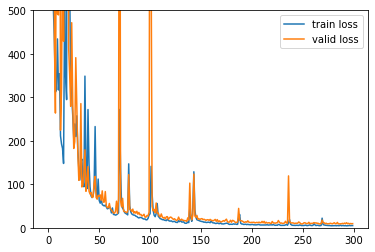

In [19]:
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='valid loss')
plt.legend()
plt.ylim(0, 500) 
plt.show()

In [20]:
model.load_weights(checkpoint_filepath)

In [95]:
def save_predictions():
    files = glob(folder + 'point_folder\\test\\' + '*.png')
    for file in files:
        name = list(file.split('\\'))[-1]
        picture = tf.io.read_file(RGBD_path + name)
        picture = tf.image.decode_png(picture)
        picture = tf.cast(picture, tf.float32)
        input_pic = np.reshape(picture, (1,256,256,4))/255.0 # 4 channels for Y-shaped Tree, 3 for grapevine/trellis
        prediction = model.predict(input_pic)#255here
        cv2.imwrite(folder + 'time_test\\' + name, prediction)

In [1]:
save_predictions()